In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.collections import LineCollection

In [2]:
from IPython.display import HTML

In [3]:

plt.rcParams["animation.html"] = "jshtml"

In [2]:
%matplotlib notebook

In [14]:
n = 2
m = 4

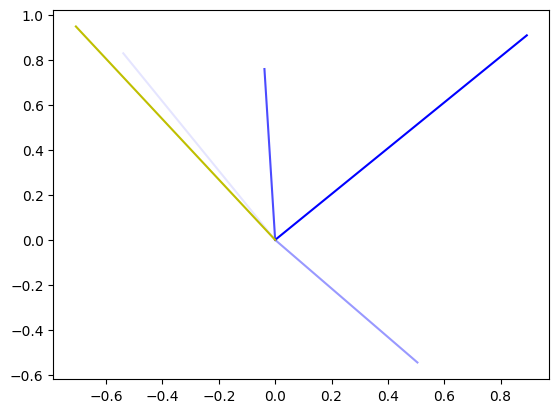

In [15]:
A = np.random.rand(n, m) * 2 - 1
# print(np.linalg.matrix_rank(a))

b = np.random.rand(n) * 2 - 1

for i, p in enumerate(A.T):
    plt.plot([0,p[0]], [0,p[1]], c='b', alpha=1-i*0.3)

plt.plot([0,b[0]], [0,b[1]], c='y')

plt.show()

In [16]:
A

array([[ 0.89294667, -0.03803511,  0.50480562, -0.53895114],
       [ 0.90783585,  0.75833812, -0.5440977 ,  0.82820807]])

In [17]:
def sol(A, b):
    global polyhedra, cc, ss

    D = A[:,:n].copy()

    while(True):
        polyhedra = np.concatenate([polyhedra, D.reshape([1,n,n])])
        lam = np.linalg.inv(D) @ b

        if(all(lam >= 0)):
            return 1, lam
            
        h = (lam < -1e-5).argmax()

        u, _, _ = np.linalg.svd(np.delete(D, h, 1))
        c = u.T[-1]
        c /= c @ D[:,h]
        cc = np.vstack([cc, c])

        ca = c @ A

        if(all(ca >= 0)):
            return 2, c

        s = (ca < -1e-5).argmax()
        ss = np.vstack([ss, A[:,s].T])

        D[:,h] = A[:,s]

In [24]:
polyhedra = np.empty([0, n, n])
cc = np.empty([0, n])
ss = np.empty([0, n])

case, res = sol(A, b)

[1.06555285 0.05344373]
[ 1.00000000e+00  2.01227923e-16  5.08818458e-01 -5.30018390e-01]
[2.19563744 1.42879711]
[3.25770038 1.         0.33096491 0.        ]


In [51]:

def draw_poly(i):
    zero = np.zeros([2])

    vert = np.vstack([zero, polyhedra[i].T * 100, zero])
    codes = np.array([2]*len(vert), dtype='uint8')
    codes[0], codes[-1] = 1, 79
    path = shade.get_paths()[0]
    path.vertices = vert
    path.codes = codes
    return

def rotate_poly(i, f):
    zero = np.zeros([2])

    v1, v2 = polyhedra[i].T
    v1n, v2n = polyhedra[i+1].T
    fix, next = (v1n, v2n) if np.linalg.norm(v2n - ss[i])<1e-8 else (v2n, v1n)
    prev = v1 if np.linalg.norm(v2 - fix)<1e-8 else v2

    fix, next, prev = fix/np.linalg.norm(fix), next/np.linalg.norm(next), prev/np.linalg.norm(prev)
    if(np.cross(fix, prev) * np.cross(fix, next) , 0):
        mid = (prev+next) / 2
        if(mid @ fix < 0):
            mid *= -1
        cur = f * mid + (0.5-f) * prev if f < 0.5 else (1-f) * mid + (f-0.5) * next
    else:
        cur = f * next + (1-f) * prev

    vert = np.vstack([zero, fix*100, cur*100, zero])
    codes = np.array([2]*len(vert), dtype='uint8')
    codes[0], codes[-1] = 1, 79
    path = shade.get_paths()[0]
    path.vertices = vert
    path.codes = codes
    return


def draw_line(i, f):
    c = cc[i] / np.linalg.norm(cc[i]) * 0.2
    x    = np.linspace(0,c[0], 100) * f
    y    = np.linspace(0,c[1], 100) * f
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    line.set_segments(segments)
    
    
def flash(s, f):
    if(0.2 <= f < 0.4 or 0.6<= f < 0.8):
        white.set_data([[0, s[0]], [0, s[1]]])
    else:
        white.set_data([[], []])

def clear_line():
    line.set_segments([])

In [59]:

def animate(frame):
    i = frame // timer_cum[-1]
    f = frame % timer_cum[-1]
    
    if(f == 1):
        draw_poly(i)
        
    ff = (f-timer_cum[0])/timer[1]
    if( 0 <= ff < 1 and i < len(cc)):
        draw_line(i, ff)

    ff = (f-timer_cum[1])/timer[2]
    if( 0 <= ff < 1):
        if(i < len(ss)):
            flash(ss[i], ff)
        elif(i == len(polyhedra)-1):
            flash(b, ff)
#             print('flash')
        
        
    if(f == timer_cum[2] and i == len(polyhedra)-1):
        clear_line()

    ff = (f-timer_cum[2])/timer[3]
    if( 0 <= ff < 1 and i < len(ss)):
        rotate_poly(i, ff)
        
    return shade, line

In [54]:
cc

array([[1.06555285, 0.05344373],
       [2.19563744, 1.42879711]])

In [ ]:
fig, ax = plt.subplots()

for p in A.T:
    plt.plot([0,p[0]], [0,p[1]], c='b')

plt.plot([0,b[0]], [0,b[1]], c='r')

white = plt.plot([0,0],[0,0], c='w')[0]
shade = plt.fill_between([0], [0], 0, facecolor = 'b', alpha = 0.1)
line = ax.add_collection(LineCollection(
            np.empty([0,2,2]), linewidths=1000, 
            alpha=0.7*np.linspace(1,0,100), color='#10B7C3', animated=True))

fps = 50

timer = np.array([30, 30, 50 ,50])
timer_cum = np.cumsum(timer)


plt.axis('scaled')

ani = animation.FuncAnimation(
    fig, animate, interval=1000//fps, blit=True, save_count=len(polyhedra)*timer_cum[-1])

# ani.save("movie.gif")
# ani.show()
ani

In [44]:
cc

array([[1.06555285, 0.05344373],
       [2.19563744, 1.42879711]])

In [42]:
polyhedra[1]

array([[-0.53895114, -0.03803511],
       [ 0.82820807,  0.75833812]])

In [4]:
fig, ax = plt.subplots()
ax.set_xlim([0,10000])

x = np.linspace(6000.,7000., 5)
y = np.ones_like(x)

collection = plt.fill_between(x, y)

def animate(i):
    path = collection.get_paths()[0]
    path.vertices[:, 1] *= 0.9

anim = animation.FuncAnimation(fig, animate,
                        frames=25, interval=30)

# anim.save("movie.gif")
anim

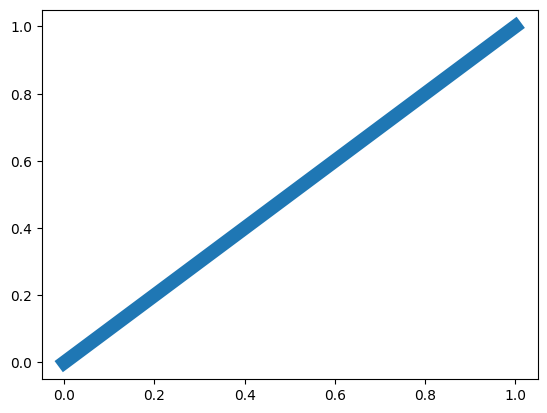

In [13]:
plt.plot([0,1],[0,1], linewidth=10)
plt.show()
# plt.savefig('fig.png')